In [1]:
from google.colab import files
uploaded = files.upload()

Saving Elements_Ordering.csv to Elements_Ordering.csv
Saving Features.csv to Features.csv


In [2]:
!pip install -q imbalanced-learn xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
pairs_df = pd.read_csv('Elements_Ordering.csv')
features_df = pd.read_csv('Features.csv')

features_df['Metal'] = features_df['Metal'].astype(str)
pairs_df['ELEMENT 1'] = pairs_df['ELEMENT 1'].astype(str)
pairs_df['ELEMENT 2'] = pairs_df['ELEMENT 2'].astype(str)

def get_combined_features(row):
    f1 = features_df[features_df['Metal'] == row['ELEMENT 1']].drop(columns='Metal').values[0]
    f2 = features_df[features_df['Metal'] == row['ELEMENT 2']].drop(columns='Metal').values[0]
    return list(f1) + list(f2)

pairs_df['combined_features'] = pairs_df.apply(get_combined_features, axis=1)
X = np.array(pairs_df['combined_features'].tolist())
y = np.array(pairs_df['ORDER'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [6]:
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [8]:
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
#Training using SVM
svm = SVC(probability=True, random_state=42)
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01], 'kernel': ['rbf']}
svm_grid = GridSearchCV(svm, svm_params, cv=cv, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train_scaled, y_train_resampled)
best_svm = svm_grid.best_estimator_

In [13]:
#Training using Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None]}
rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [14]:
#Training using Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_params = {'C': [0.1, 1.0, 10.0]}
lr_grid = GridSearchCV(lr, lr_params, cv=cv, scoring='f1', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(max_iter=1000, random_state=42,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [0.1, 1.0, 10.0]}, scoring='f1')

In [15]:
#Training using XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.05]}
xgb_grid = GridSearchCV(xgb, xgb_params, cv=cv, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train_scaled, y_train_resampled)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [3, 6],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [17]:
models = {
    'Tuned SVM': best_svm,
    'Random Forest': rf_grid.best_estimator_,
    'Logistic Regression': lr_grid.best_estimator_,
    'XGBoost': xgb_grid.best_estimator_
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    print(f"\n==== {name} ====")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.2f}")
    except:
        pass


==== Tuned SVM ====
              precision    recall  f1-score   support

           0       0.57      0.51      0.54        51
           1       0.71      0.75      0.73        80

    accuracy                           0.66       131
   macro avg       0.64      0.63      0.63       131
weighted avg       0.65      0.66      0.65       131

Accuracy: 0.66
ROC-AUC: 0.69

==== Random Forest ====
              precision    recall  f1-score   support

           0       0.61      0.65      0.63        51
           1       0.77      0.74      0.75        80

    accuracy                           0.70       131
   macro avg       0.69      0.69      0.69       131
weighted avg       0.71      0.70      0.70       131

Accuracy: 0.70
ROC-AUC: 0.76

==== Logistic Regression ====
              precision    recall  f1-score   support

           0       0.47      0.61      0.53        51
           1       0.69      0.56      0.62        80

    accuracy                           0.58    

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:58:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



==== XGBoost ====
              precision    recall  f1-score   support

           0       0.62      0.55      0.58        51
           1       0.73      0.79      0.76        80

    accuracy                           0.69       131
   macro avg       0.68      0.67      0.67       131
weighted avg       0.69      0.69      0.69       131

Accuracy: 0.69
ROC-AUC: 0.72


In [18]:
#Using a Stacking Ensemble
stack_model = StackingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_),
        ('svm', best_svm)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=cv,
    n_jobs=-1
)

stack_model.fit(X_train_scaled, y_train_resampled)
y_pred_stack = stack_model.predict(X_test_scaled)
print("\n==== Stacking Ensemble ====")
print(classification_report(y_test, y_pred_stack))
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.2f}")


==== Stacking Ensemble ====
              precision    recall  f1-score   support

           0       0.60      0.55      0.57        51
           1       0.73      0.76      0.74        80

    accuracy                           0.68       131
   macro avg       0.66      0.66      0.66       131
weighted avg       0.68      0.68      0.68       131

Accuracy: 0.68


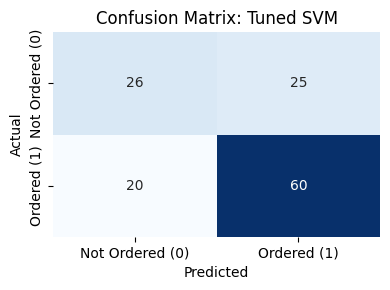

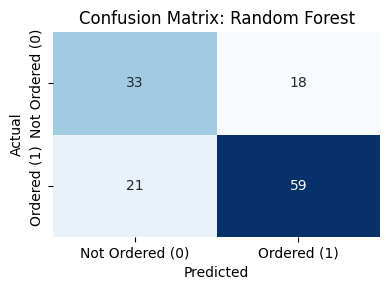

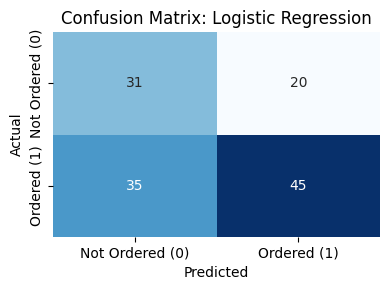

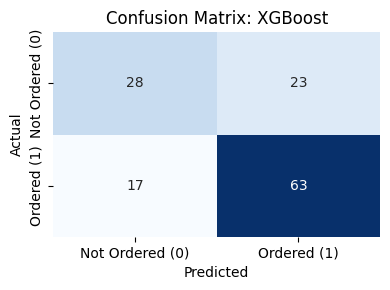

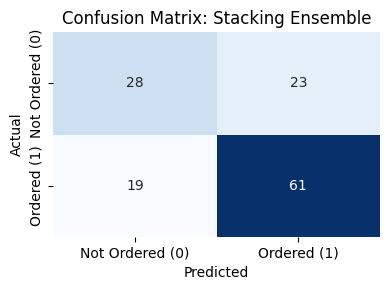

In [19]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Ordered (0)', 'Ordered (1)'],
                yticklabels=['Not Ordered (0)', 'Ordered (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    plot_confusion_matrix(y_test, y_pred, f'Confusion Matrix: {name}')
plot_confusion_matrix(y_test, y_pred_stack, 'Confusion Matrix: Stacking Ensemble')

In [28]:
#Trying Neural Networks
keras_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

keras_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = keras_model.fit(
    X_train_scaled, y_train_resampled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5394 - loss: 0.7933 - val_accuracy: 0.2887 - val_loss: 0.7785
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5776 - loss: 0.7104 - val_accuracy: 0.3814 - val_loss: 0.7544
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6481 - loss: 0.6612 - val_accuracy: 0.1649 - val_loss: 0.8563
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6928 - loss: 0.6309 - val_accuracy: 0.2577 - val_loss: 0.8124
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6618 - loss: 0.6024 - val_accuracy: 0.3918 - val_loss: 0.7714
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7193 - loss: 0.5847 - val_accuracy: 0.4433 - val_loss: 0.7356
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7147 - loss: 0.5573 - val_accuracy: 0.4536 - val_loss: 0.7296
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7196 - loss: 0.5670 - val_accuracy: 0.5155 - val_l

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step

==== Keras Neural Network ====
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        51
           1       0.78      0.78      0.78        80

    accuracy                           0.73       131
   macro avg       0.71      0.71      0.71       131
weighted avg       0.73      0.73      0.73       131

ROC-AUC: 0.7946078431372549


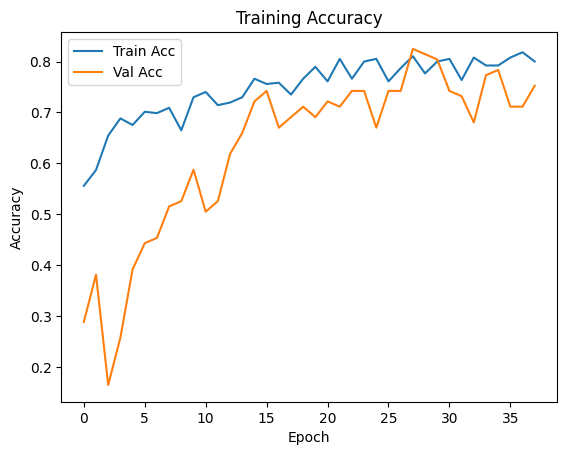

In [30]:
y_pred_prob = keras_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

print("\n==== Keras Neural Network ====")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    try:
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    except:
        roc = None
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc
    })

y_pred_stack = stack_model.predict(X_test_scaled)
y_proba_stack = stack_model.predict_proba(X_test_scaled)[:, 1]
results.append({
    'Model': 'Stacking Ensemble',
    'Accuracy': accuracy_score(y_test, y_pred_stack),
    'F1 Score': f1_score(y_test, y_pred_stack),
    'ROC-AUC': roc_auc_score(y_test, y_proba_stack)
})

y_proba_keras = keras_model.predict(X_test_scaled).ravel()
y_pred_keras = (y_proba_keras >= 0.5).astype(int)
results.append({
    'Model': 'Keras Neural Network',
    'Accuracy': accuracy_score(y_test, y_pred_keras),
    'F1 Score': f1_score(y_test, y_pred_keras),
    'ROC-AUC': roc_auc_score(y_test, y_proba_keras)
})

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

print("\n=== Model Performance Summary ===")
print(results_df)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

=== Model Performance Summary ===
                  Model  Accuracy  F1 Score   ROC-AUC
0  Keras Neural Network  0.725191  0.775000  0.794608
1               XGBoost  0.694656  0.759036  0.716912
2         Random Forest  0.702290  0.751592  0.764461
3     Stacking Ensemble  0.679389  0.743902  0.755392
4             Tuned SVM  0.656489  0.727273  0.686275
5   Logistic Regression  0.580153  0.620690  0.615196
